In [61]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#ml model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#warnings removal
import warnings
warnings.filterwarnings('ignore')

#nltk-text preprocessing/cleaning
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#train data reading
with open('CodSoft internship tasks/Task 1/Genre Classification Dataset/train_data.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

traindf = pd.DataFrame(lines, columns=['raw_data'])

In [3]:
def process_row(row):
    parts = row.split(' ::: ')
    if len(parts) >= 4:  #checking if the row has at least 4 parts
        return {
            'ID': parts[0].strip(),
            'Title': parts[1].strip(),
            'Genre': parts[2].strip(),
            'Description': parts[3].strip().rstrip(',')
        }
    return None 

In [4]:
#preprocessing data rows
processed_data = [process_row(row) for row in traindf['raw_data'] if process_row(row) is not None]
traindf_new = pd.DataFrame(processed_data)
traindf_new

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,"""54210","""""Bonino"""" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


In [5]:
traindf_new.isnull().sum()

ID             0
Title          0
Genre          0
Description    0
dtype: int64

In [6]:
traindf_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  object
 1   Title        54214 non-null  object
 2   Genre        54214 non-null  object
 3   Description  54214 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [7]:
traindf_new.describe()

,ID,Title,Genre,Description
count,54214,54214,54214,54214
unique,54214,54214,27,54096
top,1,Oscar et la dame rose (2009),drama,A retired professor has returned to his estate...
freq,1,1,13613,11


In [8]:
#test data reading
test_path = 'CodSoft internship tasks/Task 1/Genre Classification Dataset/test_data.txt'
testdf = pd.read_csv(test_path, sep=':::', names=['ID', 'Title', 'Description'])

In [9]:
testdf

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,"""54196","""""Tales of Light & Dark"""" (2013)","Covering multiple genres"", Tales of Light & D..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [10]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54200 non-null  object
 1   Title        54200 non-null  object
 2   Description  54200 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [11]:
testdf.describe()

,ID,Title,Description
count,54200,54200,54200
unique,54200,54200,54088
top,1,Edgar's Lunch (1998),Grammy - music award of the American academy ...
freq,1,1,9


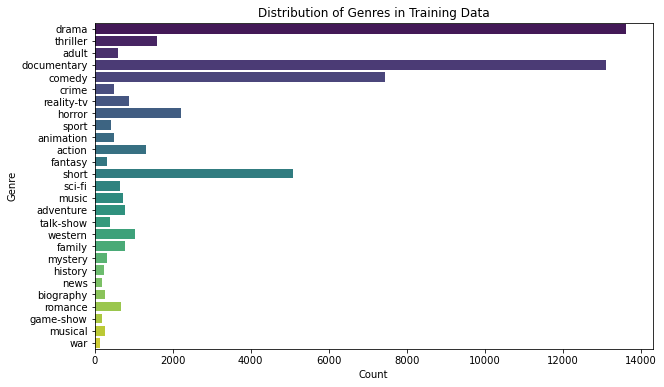

In [12]:
#traindf_new distribution of genres
plt.figure(figsize=(10, 6))
sns.countplot(y='Genre', data=traindf_new, palette='viridis')
plt.title('Distribution of Genres in Training Data')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [13]:
#text cleaning phase
#stopwords, stemmer , lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [14]:
#text preprocessing function
def preprocess_text(text):
    #to lowercase
    text = text.lower()
    #removing punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    #tokenization
    tokens = word_tokenize(text)
    #removing stopwords and applying stemming and lemmatization
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word not in stop_words]
    #rejoining tokens into a single string
    return ' '.join(tokens)

In [15]:
#text preprocessing
traindf_new['Cleaned_Description'] = traindf_new['Description'].apply(preprocess_text)
testdf['Cleaned_Description'] = testdf['Description'].apply(preprocess_text)

In [16]:
traindf_new.head(10)

,ID,Title,Genre,Description,Cleaned_Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,listen convers doctor parent yearold oscar lea...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,brother sister past incestu relationship curre...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,bu empti student field trip museum natur histo...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,help unemploy father make end meet edith twin ...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,film titl refer unrecov bodi ground zero also ...
5,6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm s...,qualiti control consist seri mm singl take sho...
6,"""7","""""Pink Slip"""" (2009)",comedy,In tough economic times Max and Joey have all ...,tough econom time max joey run idea discov sen...
7,8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen w...,ron petri keanu reev troubl teen whose life ha...
8,"""9","""""Desperate Hours"""" (2016)",reality-tv,"A sudden calamitous event"", causing great loss...",sudden calamit event caus great loss life dama...
9,10,Spirits (2014/I),horror,Four high school students embark on a terrifyi...,four high school student embark terrifi journe...


In [17]:
testdf.head(10)

,ID,Title,Description,Cleaned_Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",lr brane love life car apart job especi girlfr...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughti child three belong w...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin famili shepherd north tran...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father die hasnt spoken brother year seriou ca...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern martial art superstar bruce lee a...
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...,emili burn held captiv room idea got determin ...
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...,beauti neglect wife brilliant architect milan ...
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,vasu inamdar ina suffer disord pictur see come...
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,insight tornado hit kensal rise birmingham sur...
9,10,Press (2011),Press is a story of young people overwhelmed ...,press stori young peopl overwhelm social disco...


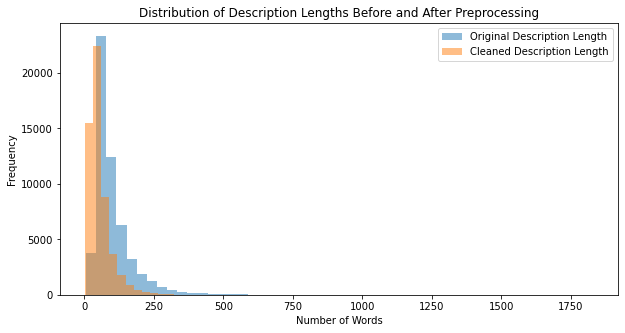

In [18]:
#plotting the length of description before and after preprocessing
traindf_new['Description_Length'] = traindf_new['Description'].apply(lambda x: len(x.split()))
traindf_new['Cleaned_Description_Length'] = traindf_new['Cleaned_Description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(traindf_new['Description_Length'], bins=50, alpha=0.5, label='Original Description Length')
plt.hist(traindf_new['Cleaned_Description_Length'], bins=50, alpha=0.5, label='Cleaned Description Length')
plt.title('Distribution of Description Lengths Before and After Preprocessing')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [19]:
#TF-IDF vectorization for the Cleaned_Description
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
x = tfidf_vectorizer.fit_transform(traindf_new['Cleaned_Description'])

In [20]:
#target variable
y = traindf_new['Genre']

In [21]:
y

0              drama
1           thriller
2              adult
3              drama
4              drama
            ...     
54209         comedy
54210         horror
54211    documentary
54212         comedy
54213        history
Name: Genre, Length: 54214, dtype: object

In [22]:
y.unique()

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

In [23]:
#encoding genre labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [24]:
y_encoded

array([ 8, 24,  1, ...,  7,  5, 12])

In [25]:
y_encoded_df = pd.DataFrame(y_encoded, columns=['Encoded Values'])
print(y_encoded_df)

       Encoded Values
0                   8
1                  24
2                   1
3                   8
4                   8
...               ...
54209               5
54210              13
54211               7
54212               5
54213              12

[54214 rows x 1 columns]


In [26]:
#getting the classes (genres) from the label encoder
genre_classes = label_encoder.classes_

#dictionary to map encoded values to genres
genre_mapping = {i: genre for i, genre in enumerate(genre_classes)}

for encoded_value, genre in genre_mapping.items():
    print(f"Encoded Value: {encoded_value} -> Genre: {genre}")

Encoded Value: 0 -> Genre: action
Encoded Value: 1 -> Genre: adult
Encoded Value: 2 -> Genre: adventure
Encoded Value: 3 -> Genre: animation
Encoded Value: 4 -> Genre: biography
Encoded Value: 5 -> Genre: comedy
Encoded Value: 6 -> Genre: crime
Encoded Value: 7 -> Genre: documentary
Encoded Value: 8 -> Genre: drama
Encoded Value: 9 -> Genre: family
Encoded Value: 10 -> Genre: fantasy
Encoded Value: 11 -> Genre: game-show
Encoded Value: 12 -> Genre: history
Encoded Value: 13 -> Genre: horror
Encoded Value: 14 -> Genre: music
Encoded Value: 15 -> Genre: musical
Encoded Value: 16 -> Genre: mystery
Encoded Value: 17 -> Genre: news
Encoded Value: 18 -> Genre: reality-tv
Encoded Value: 19 -> Genre: romance
Encoded Value: 20 -> Genre: sci-fi
Encoded Value: 21 -> Genre: short
Encoded Value: 22 -> Genre: sport
Encoded Value: 23 -> Genre: talk-show
Encoded Value: 24 -> Genre: thriller
Encoded Value: 25 -> Genre: war
Encoded Value: 26 -> Genre: western


In [27]:
#data split
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.25, random_state=42)

In [28]:
#Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [29]:
#predicting on the test set
y_test_pred_log_reg = log_reg.predict(x_test)

In [30]:
#model evaluation  
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_log_reg):.4f}")
print(classification_report(y_test, y_test_pred_log_reg, target_names=label_encoder.classes_))

Logistic Regression Performance:
Accuracy: 0.5820
              precision    recall  f1-score   support

      action       0.55      0.30      0.39       339
       adult       0.79      0.24      0.37       135
   adventure       0.38      0.16      0.22       178
   animation       0.44      0.09      0.15       126
   biography       0.00      0.00      0.00        75
      comedy       0.52      0.59      0.55      1814
       crime       0.30      0.02      0.04       142
 documentary       0.67      0.84      0.74      3296
       drama       0.54      0.78      0.64      3374
      family       0.46      0.10      0.17       187
     fantasy       0.50      0.02      0.04        90
   game-show       0.95      0.37      0.53        49
     history       0.00      0.00      0.00        61
      horror       0.67      0.59      0.62       532
       music       0.65      0.48      0.55       178
     musical       0.33      0.02      0.03        61
     mystery       0.00      0.

In [31]:
#predicting on the training set 
y_train_pred_log_reg = log_reg.predict(x_train)

#model evaluation  on the training set
print("Logistic Regression Performance on Training Data:")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_log_reg):.4f}")
print(classification_report(y_train, y_train_pred_log_reg, target_names=label_encoder.classes_))

Logistic Regression Performance on Training Data:
Training Accuracy: 0.6718
              precision    recall  f1-score   support

      action       0.68      0.43      0.53       976
       adult       0.88      0.41      0.56       455
   adventure       0.80      0.28      0.42       597
   animation       0.74      0.21      0.32       372
   biography       0.00      0.00      0.00       190
      comedy       0.64      0.71      0.67      5633
       crime       0.63      0.10      0.18       363
 documentary       0.72      0.90      0.80      9800
       drama       0.61      0.84      0.71     10239
      family       0.72      0.16      0.27       597
     fantasy       0.90      0.08      0.14       233
   game-show       0.92      0.61      0.73       145
     history       0.00      0.00      0.00       182
      horror       0.76      0.72      0.74      1672
       music       0.76      0.56      0.65       553
     musical       0.73      0.07      0.13       216
     

In [32]:
y_test_pred_log_reg

array([8, 8, 7, ..., 5, 8, 8])

In [33]:
y_train_pred_log_reg

array([8, 7, 5, ..., 8, 5, 7])

In [34]:
#decoding the predicted labels to genre names
y_test_pred = label_encoder.inverse_transform(y_test_pred_log_reg)

In [35]:
y_test_pred

array(['drama', 'drama', 'documentary', ..., 'comedy', 'drama', 'drama'],
      dtype=object)

In [36]:
#converting y_test_pred into a df
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['Predicted_Genre'])

In [37]:
y_test_pred_df

,Predicted_Genre
0,drama
1,drama
2,documentary
3,horror
4,music
...,...
13549,drama
13550,horror
13551,comedy
13552,drama


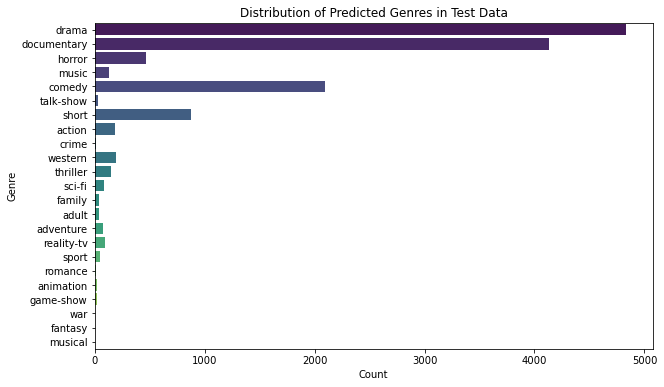

In [38]:
#the distribution of predicted genres 'only the 13.5k rows of ytest '
plt.figure(figsize=(10, 6))
sns.countplot(y='Predicted_Genre', data=y_test_pred_df, palette='viridis')
plt.title('Distribution of Predicted Genres in Test Data')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [41]:
#test solution data reading
testsol_path = 'CodSoft internship tasks/Task 1/Genre Classification Dataset/test_data_solution.txt'
testsol = pd.read_csv(testsol_path, sep=':::', names=['ID', 'Title','Genre' , 'Description'])

In [42]:
testsol

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...
...,...,...,...,...
54195,"""54196","""""Tales of Light & Dark"""" (2013)",horror,"Covering multiple genres"", Tales of Light & D..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),adult,A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard..."


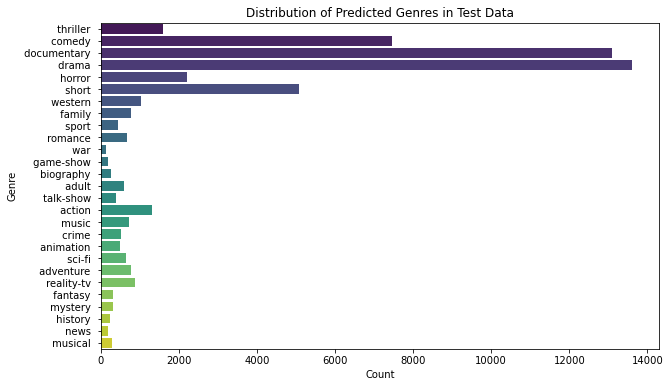

In [43]:
#the distribution of testsol genres
plt.figure(figsize=(10, 6))
sns.countplot(y='Genre', data=testsol, palette='viridis')
plt.title('Distribution of Predicted Genres in Test Data')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [50]:
#svm model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

In [51]:
#predict on the test data
y_pred_svm = svm_model.predict(x_test)

In [52]:
#model evaluation
print("Accuracy on Training Data:", accuracy_score(y_train, svm_model.predict(x_train)))
print("Accuracy on Test Data:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy on Training Data: 0.7365469749139203
Accuracy on Test Data: 0.5808617382322562
              precision    recall  f1-score   support

           0       0.46      0.35      0.40       339
           1       0.73      0.41      0.52       135
           2       0.39      0.21      0.28       178
           3       0.40      0.16      0.23       126
           4       0.00      0.00      0.00        75
           5       0.51      0.60      0.55      1814
           6       0.20      0.03      0.05       142
           7       0.67      0.83      0.74      3296
           8       0.55      0.75      0.64      3374
           9       0.36      0.10      0.15       187
          10       0.58      0.08      0.14        90
          11       0.92      0.47      0.62        49
          12       0.00      0.00      0.00        61
          13       0.65      0.60      0.62       532
          14       0.62      0.52      0.56       178
          15       0.17      0.02      0.03    

In [53]:
#manual testing: pick a random index from the test dataset
random_index = random.randint(0, len(testdf) - 1)

#getting the corresponding cleaned plot and actual genre
test_plot = testdf.iloc[random_index]['Cleaned_Description']
actual_genre = testsol.iloc[random_index]['Genre']

In [56]:
#predicting the genre for the selected plot using the SVM model
predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([test_plot]))[0]
predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

print(f"1)Testing on Plot: {test_plot[:300]}...")
print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre: {predicted_genre}")

1)Testing on Plot: henri grégoir cloutier expriest lost faith recent death granddaught zoé béliveau legal guardianship bond new owner apart build catherin émili morin help go stage grief...
Actual Genre:  drama 
Predicted Genre: drama


In [82]:
random_index = random.randint(10, len(testdf) - 1)

test_plot = testdf.iloc[random_index]['Cleaned_Description']
actual_genre = testsol.iloc[random_index]['Genre']

predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([test_plot]))[0]
predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

print(f"Testing on Plot: {test_plot[:300]}...")
print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre: {predicted_genre}") 

Testing on Plot: hookup break up best friend chiara leila sharon learn true mean phrase men use love get sex woman use sex find love explor atlanta date scene new found perspect compris core belief threaten friendship...
Actual Genre:  drama 
Predicted Genre: comedy


In [83]:
random_index = random.randint(10000, len(testdf) - 1)

test_plot = testdf.iloc[random_index]['Cleaned_Description']
actual_genre = testsol.iloc[random_index]['Genre']

predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([test_plot]))[0]
predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

print(f"Testing on Plot: {test_plot[:300]}...")
print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre: {predicted_genre}") 

Testing on Plot: brief televis product show process turn live mink cage dead mink wear winter includ slaughter trade unprocess fur design sale final product interview key player everi part process film neutral still rather unsettl due pictur fur torn anim saw sit cage moment...
Actual Genre:  documentary 
Predicted Genre: documentary


In [84]:
random_index = random.randint(555, len(testdf) - 1)

test_plot = testdf.iloc[random_index]['Cleaned_Description']
actual_genre = testsol.iloc[random_index]['Genre']

predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([test_plot]))[0]
predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

print(f"Testing on Plot: {test_plot[:300]}...")
print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre: {predicted_genre}") 

Testing on Plot: ob compuls man battl control relationship partner idea extent power max emili coupl live world reclus never go outsid keep dark confin hous howev increasingli gloomi environ intrigu emili attract gleam light outsid world decid want ventur obtain job max great difficulti accept fear loo emili gradual...
Actual Genre:  short 
Predicted Genre: drama


In [70]:
#testing several random samples
#the number of random samples you want to test
num_samples = 5 

for i in range(num_samples):
    #pick a random index from the test dataset
    random_index = random.randint(10, len(testdf) - 1)
    
    #getting the corresponding cleaned plot and actual genre
    test_plot = testdf.iloc[random_index]['Cleaned_Description']
    actual_genre = testsol.iloc[random_index]['Genre']

    #predicting the genre for the selected plot using the SVM model
    predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([test_plot]))[0]
    predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

    # Print the results
    print(f"Sample {i+1}:")
    print(f"Testing on Plot: {test_plot[:300]}...")
    print(f"Actual Genre: {actual_genre}")
    print(f"Predicted Genre: {predicted_genre}")
    print("-" * 50)  #separator line for clarity


Sample 1:
Testing on Plot: ralf milan hitman arriv montpelli kill import wit check hotel without know neighbour becom neurot wife left...
Actual Genre:  comedy 
Predicted Genre: comedy
--------------------------------------------------
Sample 2:
Testing on Plot: bum becom butler millionair famili turn millionair brink financi ruin also turn bum whizkid stockbrok millionair daughter set rehabilit bumbutl process save famili...
Actual Genre:  adult 
Predicted Genre: comedy
--------------------------------------------------
Sample 3:
Testing on Plot: success glass artist stellan sylvest end hospit car accid look back life find empti meaningless fall love nurs marta find engag life turn even meaningless...
Actual Genre:  drama 
Predicted Genre: drama
--------------------------------------------------
Sample 4:
Testing on Plot: young doctor former partisan leader hero murder wife victim minion totalitarian regim lover polit careerist naiv singl mother betray fate dramat fate antihero era ri

In [62]:
#testing on a new movie description
new_description = "A young boy discovers he has magical powers and goes on an adventure to a wizarding school."

#preprocessing the new description
new_description_cleaned = preprocess_text(new_description)

In [63]:
new_description_cleaned

'young boy discov magic power goe adventur wizard school'

In [64]:
#transforming the description using the trained TF-IDF vectorizer
new_description_tfidf = tfidf_vectorizer.transform([new_description_cleaned])

In [66]:
#predicting the genre using both models
predicted_genre_svm = svm_model.predict(new_description_tfidf)
predicted_genre_log_reg = log_reg.predict(new_description_tfidf)

In [67]:
#decoding the predicted labels
predicted_genre_svm_decoded = label_encoder.inverse_transform(predicted_genre_svm)
predicted_genre_log_reg_decoded = label_encoder.inverse_transform(predicted_genre_log_reg)

In [68]:
print(f"Predicted Genre (SVM): {predicted_genre_svm_decoded[0]}")
print(f"Predicted Genre (Logistic Regression): {predicted_genre_log_reg_decoded[0]}")

Predicted Genre (SVM): animation
Predicted Genre (Logistic Regression): animation


In [69]:
#the actual genre of this movie description
actual_genre = "Fantasy"

print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre (SVM): {predicted_genre_svm_decoded[0]}")
print(f"Predicted Genre (Logistic Regression): {predicted_genre_log_reg_decoded[0]}")

#evaluating the correctness
is_correct_svm = actual_genre == predicted_genre_svm_decoded[0]
is_correct_log_reg = actual_genre == predicted_genre_log_reg_decoded[0]

print(f"Is the SVM prediction correct? {'Yes' if is_correct_svm else 'No'}")
print(f"Is the Logistic Regression prediction correct? {'Yes' if is_correct_log_reg else 'No'}")

Actual Genre: Fantasy
Predicted Genre (SVM): animation
Predicted Genre (Logistic Regression): animation
Is the SVM prediction correct? No
Is the Logistic Regression prediction correct? No


In [71]:
#some new descriptions and their likely genres
test_plots = [
    {"plot": "A group of friends find themselves in a haunted house with no way out, and must solve puzzles to survive.", 
     "actual_genre": "Horror, Thriller"},
    
    {"plot": "In a dystopian future, a lone warrior battles against a tyrannical government to free the oppressed.", 
     "actual_genre": "Action, Sci-Fi"},
    
    {"plot": "A young woman falls in love with a mysterious man who has a dark secret.", 
     "actual_genre": "Romance, Mystery"},
    
    {"plot": "A detective investigates a series of murders in a small town, uncovering a web of lies and deceit.", 
     "actual_genre": "Crime, Mystery, Thriller"},
    
    {"plot": "A spaceship crew is sent on a mission to explore a distant planet, only to discover an ancient alien civilization.", 
     "actual_genre": "Sci-Fi, Adventure"}
]

In [72]:
#randomly pick a plot from the list
random_index = random.randint(0, len(test_plots) - 1)
selected_plot = test_plots[random_index]['plot']
actual_genre = test_plots[random_index]['actual_genre']

#predicting the genre using the SVM model
predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([selected_plot]))[0]
predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

print(f"Testing on Plot: {selected_plot[:300]}...")
print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre: {predicted_genre}")

Testing on Plot: A spaceship crew is sent on a mission to explore a distant planet, only to discover an ancient alien civilization....
Actual Genre: Sci-Fi, Adventure
Predicted Genre: sci-fi


In [73]:
random_index = random.randint(0, len(test_plots) - 1)
selected_plot = test_plots[random_index]['plot']
actual_genre = test_plots[random_index]['actual_genre']

predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([selected_plot]))[0]
predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]

print(f"Testing on Plot: {selected_plot[:300]}...")
print(f"Actual Genre: {actual_genre}")
print(f"Predicted Genre: {predicted_genre}")

Testing on Plot: A detective investigates a series of murders in a small town, uncovering a web of lies and deceit....
Actual Genre: Crime, Mystery, Thriller
Predicted Genre: comedy


In [78]:
#some new descriptions and their likely genres
test_plots2 = [
    {"plot": "A group of friends find themselves in a haunted house with no way out, and must solve puzzles to survive.", 
     "actual_genre": "Horror, Thriller"},
    
    {"plot": "In a dystopian future, a lone warrior battles against a tyrannical government to free the oppressed.", 
     "actual_genre": "Action, Sci-Fi"},
    
    {"plot": "A young woman falls in love with a mysterious man who has a dark secret.", 
     "actual_genre": "Romance, Mystery"},
    
     
    {"plot": "A family moves to a new town and discovers that their neighbors are all vampires.", 
     "actual_genre": "Horror, Mystery"},
    
    {"plot": "A struggling artist finds inspiration in the most unexpected places, leading to a successful career.", 
     "actual_genre": "Drama"},
    
    {"plot": "An elite team of soldiers is sent on a mission to retrieve a powerful artifact from enemy territory.", 
     "actual_genre": "Action, Adventure"},
    
    {"plot": "A scientist accidentally discovers a way to travel through time, leading to unintended consequences.", 
     "actual_genre": "Sci-Fi"},
    
    {"plot": "A young boy befriends a talking dog with a mysterious past.", 
     "actual_genre": "Family, Fantasy"}
]


In [81]:
#loop through each plot description
for item in test_plots2:
    #preprocess the plot description
    cleaned_plot = preprocess_text(item['plot'])
    actual_genre = item['actual_genre']
    
    predicted_genre_encoded = svm_model.predict(tfidf_vectorizer.transform([cleaned_plot]))[0]
    predicted_genre = label_encoder.inverse_transform([predicted_genre_encoded])[0]
    
    print(f"Testing on Plot: {item['plot'][:300]}...")
    print(f"Cleaned Plot: {cleaned_plot[:300]}...")
    print(f"Actual Genre: {actual_genre}")
    print(f"Predicted Genre: {predicted_genre}")
    print('-' * 80)

Testing on Plot: A group of friends find themselves in a haunted house with no way out, and must solve puzzles to survive....
Cleaned Plot: group friend find haunt hous way must solv puzzl surviv...
Actual Genre: Horror, Thriller
Predicted Genre: horror
--------------------------------------------------------------------------------
Testing on Plot: In a dystopian future, a lone warrior battles against a tyrannical government to free the oppressed....
Cleaned Plot: dystopian futur lone warrior battl tyrann govern free oppress...
Actual Genre: Action, Sci-Fi
Predicted Genre: drama
--------------------------------------------------------------------------------
Testing on Plot: A young woman falls in love with a mysterious man who has a dark secret....
Cleaned Plot: young woman fall love mysteri man dark secret...
Actual Genre: Romance, Mystery
Predicted Genre: drama
--------------------------------------------------------------------------------
Testing on Plot: A family moves to a new 